In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from dtaidistance import dtw
import random

In [15]:
file_path = 'BTCUSDT.csv'
data = pd.read_csv(file_path)

data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

train_start = '2020-01-01 00:00:00'
train_end   = '2020-05-30 23:59:00'
test_start  = '2020-06-01 00:00:00'
test_end    = '2020-08-30 23:59:00'

train_data = data.loc[train_start:train_end]
test_data  = data.loc[test_start:test_end]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data[['open']])
test_scaled  = scaler.transform(test_data[['open']])

train_torch = torch.tensor(train_scaled, dtype=torch.float32)
test_torch  = torch.tensor(test_scaled,  dtype=torch.float32)

/tmp/ipykernel_16203/2717123376.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [3]:
def create_sequences(data_tensor, seq_length):
    sequences = []
    for i in range(len(data_tensor) - seq_length):
        seq = data_tensor[i:i + seq_length]
        sequences.append(seq)
    return torch.stack(sequences)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_dims=[64, 32, 16]):
        super(Autoencoder, self).__init__()
        # Encoder
        encoder_layers = []
        curr_size = input_size
        for hd in hidden_dims:
            encoder_layers.append(nn.Linear(curr_size, hd))
            encoder_layers.append(nn.ReLU())
            curr_size = hd
        
        # Decoder
        decoder_layers = []
        hidden_dims.reverse()
        for hd in hidden_dims[1:]:
            decoder_layers.append(nn.Linear(curr_size, hd))
            decoder_layers.append(nn.ReLU())
            curr_size = hd
        
        decoder_layers.append(nn.Linear(curr_size, input_size))
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)      #(batch_size, seq_length*features) flatten
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), -1)  # reshape back
        return decoded

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  
        return out

In [17]:
class CNNModel(nn.Module):
    """
    CNN-based model for reconstruction-based anomaly detection.
    """
    def __init__(self, input_size, out_channels=16, kernel_size=3):
        super(CNNModel, self).__init__()
        # 1 feature, channel=1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels, 
                               kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        # Flatten -> fully connected -> reshape
        self.fc = nn.Linear(out_channels * input_size, input_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, 1) 
        x = x.transpose(1, 2)   # shape: (batch_size, 1, seq_len)
        x = self.conv1(x)       # (batch_size, out_channels, seq_len)
        x = self.relu(x)
        x = x.reshape(x.size(0), -1)  # flatten to (batch_size, out_channels * seq_len)
        x = self.fc(x)             # (batch_size, input_size)
        return x.unsqueeze(-1)     # (batch_size, input_size, 1)


In [7]:
class StackVAEG(nn.Module):
    def __init__(self, input_size, hidden_dims=[64, 32], latent_dim=16):
        super(StackVAEG, self).__init__()
        self.input_size = input_size
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        
        # Encoder
        encoder_layers = []
        in_dim = self.input_size
        for hdim in self.hidden_dims:
            encoder_layers.append(nn.Linear(in_dim, hdim))
            encoder_layers.append(nn.ReLU())
            in_dim = hdim
        self.encoder = nn.Sequential(*encoder_layers)
        
        self.fc_mu = nn.Linear(in_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(in_dim, self.latent_dim)
        
        # Decoder
        decoder_layers = []
        out_dim = self.hidden_dims[-1]
        decoder_layers.append(nn.Linear(self.latent_dim, out_dim))
        decoder_layers.append(nn.ReLU())
        for hdim in reversed(self.hidden_dims[:-1]):
            decoder_layers.append(nn.Linear(out_dim, hdim))
            decoder_layers.append(nn.ReLU())
            out_dim = hdim
        decoder_layers.append(nn.Linear(out_dim, self.input_size))
        
        self.decoder = nn.Sequential(*decoder_layers)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        # Flatten
        x = x.view(x.size(0), -1)
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        
        return reconstructed.view(x.size(0), -1), mu, logvar

In [8]:
class OmniAnomaly(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, latent_dim=16, num_layers=1):
        super(OmniAnomaly, self).__init__()
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        
        # LSTM Encoder
        self.lstm_enc = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, latent_dim)
        self.fc_logvar = nn.Linear(hidden_size, latent_dim)
        
        # LSTM Decoder
        self.lstm_dec = nn.LSTM(latent_dim, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, input_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        enc_out, _ = self.lstm_enc(x)  
        mu = self.fc_mu(enc_out)       # (batch_size, seq_len, latent_dim)
        logvar = self.fc_logvar(enc_out)
        
        z = self.reparameterize(mu, logvar)  # (batch_size, seq_len, latent_dim)
        
        dec_out, _ = self.lstm_dec(z)
        reconstructed = self.fc_out(dec_out)  # (batch_size, seq_len, input_size)
        
        return reconstructed, mu, logvar

In [9]:
class EGADSModel:
    def __init__(self, window=30):
        self.window = window
        self.train_length_ = None

    def fit(self, data):
        data = data.flatten()
        self.train_length_ = len(data)
        
    def predict(self, data):
        data = data.flatten()
        full_series = pd.Series(data)
        roll_mean = full_series.rolling(self.window).mean()
        roll_std  = full_series.rolling(self.window).std()

        roll_mean = roll_mean[self.window - 1:]
        roll_std  = roll_std[self.window - 1:]
        valid_data = data[self.window - 1:]
        z_scores = np.abs(valid_data - roll_mean) / (roll_std + 1e-8)
        
        anomaly_scores = np.zeros(len(data))
        anomaly_scores[self.window - 1:] = z_scores
        return anomaly_scores

In [32]:
class DTWModel:
    def __init__(self, window=30, n_references=10, seed=42):
        self.window = window
        self.n_references = n_references
        self.references = []
        self.seed = seed
    
    def fit(self, train_sequences):
        np.random.seed(self.seed)
        total_sequences = train_sequences.shape[0]
        selected_indices = np.random.choice(total_sequences, self.n_references, replace=False)
        self.references = [train_sequences[i].squeeze().numpy() for i in selected_indices]
        print(f"DTWModel: Selected {self.n_references} reference sequences.")
    
    def predict(self, test_sequences):
        scores = []
        for seq in test_sequences:
            seq_np = seq.squeeze().numpy()
            distances = [dtw.distance(seq_np, ref) for ref in self.references]
            min_distance = min(distances)
            scores.append(min_distance)
        return np.array(scores)

In [34]:
class AnomalyDetector:
    def __init__(self, model_name, model_params, sequence_length=30, device='cpu'):
        self.model_name = model_name.lower()
        self.model_params = model_params
        self.sequence_length = sequence_length
        self.device = device
        
        if self.model_name == 'egads':
            self.model = EGADSModel(**self.model_params)
        elif self.model_name == 'dtw':
            self.model = DTWModel(**self.model_params)
        else:
            self.model = self._initialize_model().to(self.device)
        
    def _initialize_model(self):
        if self.model_name == 'autoencoder':
            return Autoencoder(**self.model_params)
        elif self.model_name == 'lstm':
            return LSTMModel(**self.model_params)
        elif self.model_name == 'cnn':
            return CNNModel(**self.model_params)
        elif self.model_name == 'stackvaeg':
            return StackVAEG(**self.model_params)
        elif self.model_name == 'omnianomaly':
            return OmniAnomaly(**self.model_params)
        else:
            raise ValueError(f"Unknown model_name: {self.model_name}")
    
    def train(self, train_sequences=None, num_epochs=10, batch_size=32, learning_rate=1e-3, train_raw=None):
        if self.model_name == 'egads':
            if train_raw is None:
                raise ValueError("EGADS requires 'train_raw'")
            data_np = train_raw.cpu().numpy().flatten()
            self.model.fit(data_np)
            return
        elif self.model_name == 'dtw':
            if train_sequences is None:
                raise ValueError("DTW requires 'train_sequences'")
            self.model.fit(train_sequences)
            return
        
        if train_sequences is None:
            raise ValueError(f"{self.model_name} requires 'train_sequences'")
        
        train_loader = torch.utils.data.DataLoader(train_sequences, batch_size=batch_size, shuffle=True)
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        self.model.train()
        for epoch in tqdm(range(num_epochs), desc=f"Training {self.model_name}"):
            running_loss = 0.0
            for batch in train_loader:
                batch = batch.to(self.device)
                optimizer.zero_grad()
                
                if self.model_name in ['stackvaeg', 'omnianomaly']:
                    if self.model_name == 'stackvaeg':
                        outputs, mu, logvar = self.model(batch)
                        batch_flat = batch.view(batch.size(0), -1)
                        recon_loss = nn.MSELoss()(outputs, batch_flat)
                    else:  
                        reconstructed, mu, logvar = self.model(batch)
                        recon_loss = nn.MSELoss()(reconstructed, batch)
                    # KLD
                    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                    loss = recon_loss + kld * 0.001
                else:
                    outputs = self.model(batch)
                    if self.model_name == 'cnn':
                        loss = nn.MSELoss()(outputs, batch.view_as(outputs))
                    elif self.model_name == 'lstm':
                        loss = nn.MSELoss()(outputs, batch)
                    else:
                        loss = nn.MSELoss()(outputs, batch.view(outputs.size()))
                
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            epoch_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

    def predict(self, test_sequences=None, test_raw=None):
        if self.model_name == 'egads':
            if test_raw is None:
                raise ValueError("EGADS requires 'test_raw'")
            scores = self.model.predict(test_raw.cpu().numpy().flatten())
            return scores
        elif self.model_name == 'dtw':
            if test_sequences is None:
                raise ValueError("DTW requires 'test_sequences'")
            scores = self.model.predict(test_sequences)
            return scores
        
        self.model.eval()
        all_errors = []
        with torch.no_grad():
            for i in range(len(test_sequences)):
                x = test_sequences[i].unsqueeze(0).to(self.device)
                if self.model_name in ['stackvaeg', 'omnianomaly']:
                    if self.model_name == 'stackvaeg':
                        outputs, _, _ = self.model(x)
                        target = x.view(1, -1)
                        mse = torch.mean((outputs - target) ** 2, dim=1)
                    else:
                        reconstructed, _, _ = self.model(x)
                        mse = torch.mean((reconstructed - x) ** 2, dim=[1,2])
                else:
                    outputs = self.model(x)
                    if self.model_name == 'cnn':
                        mse = torch.mean((outputs - x.view_as(outputs)) ** 2, dim=[1,2])
                    elif self.model_name == 'lstm':
                        mse = torch.mean((outputs - x) ** 2, dim=[1,2])
                    else:
                        # autoencoder
                        mse = torch.mean((outputs - x.view(1, -1)) ** 2, dim=1)
                all_errors.append(mse.item())
        return np.array(all_errors)
    
    def get_anomalies(self, errors, percentile=99.5):
        threshold = np.percentile(errors, percentile)
        anomalies = errors > threshold
        return anomalies, threshold


In [36]:
model_names = ['autoencoder', 'lstm', 'cnn', 'stackvaeg', 'omnianomaly', 'egads', 'dtw'] ######

model_params = {
    'autoencoder': {
        'input_size': sequence_length * 1,  
        'hidden_dims': [64, 32, 16]
    },
    'lstm': {
        'input_size': 1,     
        'hidden_size': 32,
        'num_layers': 1
    },
    'cnn': {
        'input_size': sequence_length,
        'out_channels': 16,
        'kernel_size': 3
    },
    'stackvaeg': {
        'input_size': sequence_length * 1,  
        'hidden_dims': [64, 32],
        'latent_dim': 16
    },
    'omnianomaly': {
        'input_size': 1,     
        'hidden_size': 32,
        'latent_dim': 16,
        'num_layers': 1
    },
    'egads': {
        'window': 30
    },
    'dtw': {
        'window': 30,
        'n_references': 10,
        'seed': 42
    }
}


=== Processing Model: egads ===
Model: egads
Anomaly Threshold (z-score): 3.353454
Number of Anomalies Detected: 656 out of 131040


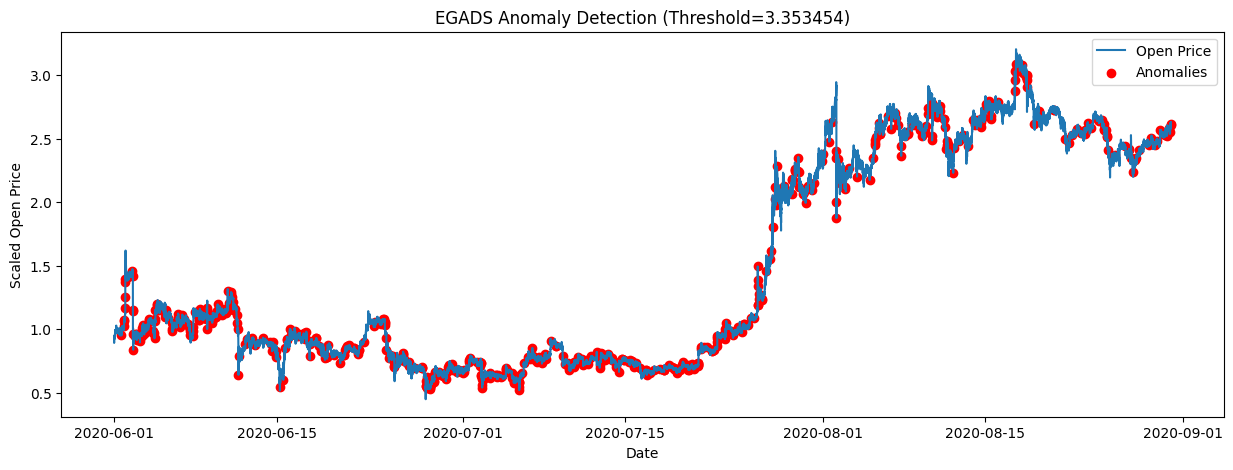


=== Processing Model: dtw ===
DTWModel: Selected 10 reference sequences.


In [ ]:

for model_name in model_names:
    print(f"\n=== Processing Model: {model_name} ===")
    
    params = model_params[model_name]
    
    detector = AnomalyDetector(
        model_name=model_name,
        model_params=params,
        sequence_length=sequence_length,
        device='cpu' 
    )
    
    if model_name not in ['egads', 'dtw']:  
        detector.train(
            train_sequences=train_sequences,
            num_epochs=10,          
            batch_size=32,          
            learning_rate=1e-3      
        )
    elif model_name == 'egads':
        detector.train(
            train_sequences=None,    
            train_raw=train_torch   
        )
    elif model_name == 'dtw':
        detector.train(
            train_sequences=train_sequences,  
            num_epochs=0,
            batch_size=0,
            learning_rate=0,
            train_raw=None 
        )
    
    if model_name not in ['egads', 'dtw']:
        scores = detector.predict(test_sequences=test_sequences)
        anomalies, threshold = detector.get_anomalies(scores, percentile=99.5)
        
        print(f"Model: {model_name}")
        
        plt.figure(figsize=(15, 5))
        plt.plot(test_dates, test_torch[sequence_length:].numpy(), label='Open Price')
        
        anomaly_dates = test_dates[anomalies]
        anomaly_prices = test_torch[sequence_length:][anomalies].numpy()
        
        plt.scatter(anomaly_dates, anomaly_prices, color='red', label='Anomalies')
        plt.title(f'{model_name.capitalize()} Anomaly Detection')
        plt.xlabel('Date')
        plt.ylabel('Scaled Open Price')
        plt.legend()
        plt.show()
    elif model_name == 'egads':
        scores = detector.predict(test_raw=test_torch)
        anomalies, threshold = detector.get_anomalies(scores, percentile=99.5)
        
        print(f"Model: {model_name}")
        
        plt.figure(figsize=(15, 5))
        plt.plot(test_data.index, test_torch.numpy(), label='Open Price')
        
        anomaly_dates = test_data.index[anomalies]
        anomaly_prices = test_torch.numpy()[anomalies]
        
        plt.scatter(anomaly_dates, anomaly_prices, color='red', label='Anomalies')
        plt.title(f'{model_name.upper()} Anomaly Detection')
        plt.xlabel('Date')
        plt.ylabel('Scaled Open Price')
        plt.legend()
        plt.show()
    elif model_name == 'dtw':
        scores = detector.predict(test_sequences=test_sequences)
        anomalies, threshold = detector.get_anomalies(scores, percentile=99.5)
        
        print(f"Model: {model_name}")
        
        plt.figure(figsize=(15, 5))
        plt.plot(test_dates, test_torch[sequence_length:].numpy(), label='Open Price')
        
        anomaly_dates = test_dates[anomalies]
        anomaly_prices = test_torch[sequence_length:][anomalies].numpy()
        
        plt.scatter(anomaly_dates, anomaly_prices, color='red', label='Anomalies')
        plt.title(f'DTW Anomaly Detection')
        plt.xlabel('Date')
        plt.ylabel('Scaled Open Price')
        plt.legend()
        plt.show()
